# Convert to isoparametric coordinate

2021.04.23 Kurama Okubo (ball drop version)

2022.02.14 updated for AE moment tensor inversion

2022.05.08 updated for AE events of fb03-045 for JpGU022

2023.10.22 updated for fb03-087

2024.2.6 updated for master plot: compute the incident angle for each pair of isocoord source location and the AE sensor, which is used to correct the aperture effect.

2024.10.31 update for the merged catalog.

The event location $(\xi, \eta)$ and station $(x_s, y_s= \pm W/2)$ on the global coordinate is converted on the sensor-local coordinate $\boldsymbol{\xi}'$ as:

$$
 \boldsymbol{\xi}' = \begin{cases}
   [ -x_s +\xi, \eta - \dfrac{W}{2}], ~~ y_s \geq 0 \\
   [ x_s - \xi, -(\eta + \dfrac{W}{2})], ~~ y_s < 0
  \end{cases}
$$

<img src="Isoparametric_coordinate_noedge_AEevent.png" alt="isoparacoord" width="400"/>


## Parameters

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from obspy.core.utcdatetime import UTCDateTime    
from tqdm import tqdm
import warnings

from matplotlib.patches import Rectangle, Circle, Ellipse

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


In [2]:
figdir = "../figure/isocoord"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
# Path for event location table
eventloc_table = "../data/datacsv/AE_obs_location.csv"

# Directory for picked waveforms
datadir = "../data/03_AEobs_waveform"

# Data outputdir
outdir = "../data/04_AE_obs_isocoord"

# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'


In [4]:
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Read event loc

In [5]:
df_eventloc = pd.read_csv(eventloc_table, index_col=0)
# df_eventloc = df_eventloc.set_index("foreshock_id")
df_eventloc["Z"] = 0
df_eventloc["datacase"] = df_eventloc.apply(lambda row: "{}__{:04d}".format(row.exprID, row.name), axis=1)
df_eventloc.head()

,stickslip_id,exprID,origin_time,X,Y,V,Vs,dx_best,dy_best,Z,datacase
gougeevent_id,,,,,,,,,,,
4,3,fb03-087,42.474772,1.7475,0.00505,6200,3600,0.0,-0.0002,0,fb03-087__0004
9,5,fb03-087,47.662693,1.7425,0.00375,6200,3600,0.0,0.0000,0,fb03-087__0009
18,8,fb03-087,56.727044,1.7460,0.00375,6200,3600,0.0,0.0000,0,fb03-087__0018
19,9,fb03-087,59.103175,1.7425,0.00300,6200,3600,0.0,0.0000,0,fb03-087__0019
20,9,fb03-087,59.103526,1.7460,0.00325,6200,3600,0.0,0.0010,0,fb03-087__0020


## Read channel array

In [6]:
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
channel_loc

{'OL01': [190.0, 50.0, 70.0],
 'OL02': [410.0, 50.0, 70.0],
 'OL03': [640.0, 50.0, 70.0],
 'OL04': [910.0, 50.0, 70.0],
 'OL05': [1160.0, 50.0, 70.0],
 'OL06': [1370.0, 50.0, 70.0],
 'OL07': [1660.0, 50.0, 70.0],
 'OL08': [1910.0, 50.0, 70.0],
 'OL09': [2160.0, 50.0, 70.0],
 'OL10': [2410.0, 50.0, 70.0],
 'OL11': [2650.0, 50.0, 70.0],
 'OL12': [2910.0, 50.0, 70.0],
 'OL13': [3160.0, 50.0, 70.0],
 'OL14': [3410.0, 50.0, 70.0],
 'OL15': [3660.0, 50.0, 70.0],
 'OL16': [3910.0, 50.0, 70.0],
 'OL17': [285.0, -50.0, 70.0],
 'OL18': [535.0, -50.0, 70.0],
 'OL19': [785.0, -50.0, 70.0],
 'OL20': [1035.0, -50.0, 70.0],
 'OL21': [1285.0, -50.0, 70.0],
 'OL22': [1535.0, -50.0, 70.0],
 'OL23': [1785.0, -50.0, 70.0],
 'OL24': [2035.0, -50.0, 70.0],
 'OL25': [2285.0, -50.0, 70.0],
 'OL26': [2535.0, -50.0, 70.0],
 'OL27': [2785.0, -50.0, 70.0],
 'OL28': [3035.0, -50.0, 70.0],
 'OL29': [3285.0, -50.0, 70.0],
 'OL30': [3535.0, -50.0, 70.0],
 'OL31': [3785.0, -50.0, 70.0],
 'OL32': [4035.0, -50.0, 70.0]}

## Search events close to AE sensor

This process searches the pair of sensor and events. We assign datacase name as experimental id + event id, such that "fb03-XXX__XXXX".

## Compute incident angle to correct the aperture effect

The backazimuth of source, i.e., incident angle, is computed as follows:
$$ \theta=\arccos \left( \dfrac{\mathbf{x} \cdot \mathbf{n}}{|\mathbf{x}|} \right)$$
$$ \mathbf{x} = (\xi, \eta, -z_{rec}) $$
$$ \mathbf{n} = (0, -1, 0) $$
where $\mathbf{x}$ is the source vector, and $\mathbf{n}$ is normal vector of receiver from side surface. Iso-coordinates are used in this representation.

In [7]:
df_iso_all = pd.DataFrame(columns=['OL', 'datacase', 'xs', 'ys', 'zs', 'xi', 'eta', 'zeta', 'xi1', 'eta1', 'zeta1', 'incidentangle', 'azimuth', 'rlen_sourcedist', 'llen'])
AEsensors = list(channel_loc.keys())
max_dist = 400 # [mm] search distance; compute green's function within this souce distance.
W = 100; #[mm]

In [8]:
df_eventloc.head()

,stickslip_id,exprID,origin_time,X,Y,V,Vs,dx_best,dy_best,Z,datacase
gougeevent_id,,,,,,,,,,,
4,3,fb03-087,42.474772,1.7475,0.00505,6200,3600,0.0,-0.0002,0,fb03-087__0004
9,5,fb03-087,47.662693,1.7425,0.00375,6200,3600,0.0,0.0000,0,fb03-087__0009
18,8,fb03-087,56.727044,1.7460,0.00375,6200,3600,0.0,0.0000,0,fb03-087__0018
19,9,fb03-087,59.103175,1.7425,0.00300,6200,3600,0.0,0.0000,0,fb03-087__0019
20,9,fb03-087,59.103526,1.7460,0.00325,6200,3600,0.0,0.0010,0,fb03-087__0020


In [9]:
# df_eventloc

In [10]:
channel_loc["OL15"]

[3660.0, 50.0, 70.0]

In [11]:
for stnm in AEsensors:
    df_iso = pd.DataFrame(columns=['OL', 'datacase', 'xs', 'ys', 'zs', 'xi', 'eta', 'zeta', 'xi1', 'eta1', 'zeta1', 'incidentangle', 'azimuth', 'rlen_sourcedist', 'llen'])

    # stnm = AEsensors[8]
    station_loc = channel_loc[stnm]
    xs, ys, zs = station_loc
    eventind = []

    # find events within max_dist
    for index, row in df_eventloc.iterrows():
        source_loc = np.array([row['X'], row['Y'], row['Z']])*1e3 #[mm]
        dist = np.linalg.norm(source_loc-station_loc)
        if stnm=="OL07":
            print(dist)
        if dist <= max_dist:
            eventind.append(index)

    if not eventind:
        continue; # no event occur near this station

    # Shift coordinates
    for eid in eventind:
#         datacase, xi, eta, zeta, Er = df_eventloc.loc[eid].values
        df_tmp_evloc = df_eventloc.loc[eid]
        datacase = df_tmp_evloc["datacase"]
        xi = df_tmp_evloc["X"]
        eta = df_tmp_evloc["Y"]
        zeta = df_tmp_evloc["Z"]
        
        if ys >= 0:
            # OL01-16
            xi1, eta1, zeta1 = [-xs/1e3 + xi, eta-W/2/1e3, 0] #[m]
            dist1 = np.linalg.norm([xi1, eta1, zeta1])
        elif ys < 0:
            # OL17-32
            xi1, eta1, zeta1 = [xs/1e3 - xi, -(eta + W/2/1e3), 0] #[m]
            dist1 = np.linalg.norm([xi1, eta1, zeta1])

        #---update 2024.2.6 compute the incident angle to correct the aperture effect---#
        rx, ry, rz = [0.0, 0.0, 70.0e-3]
        nvec = [0, -1, 0]
        xvec = (xi1, eta1, -rz)
        rlen = np.linalg.norm(xvec, ord=2)
        incidentangle = np.rad2deg(np.arccos(np.dot(xvec, nvec)/rlen))

        # compute azimuth: angle projected on fault
        azimuth = np.rad2deg(np.arctan2(xi1, np.abs(eta1)))

        #--------------------------------#
        
        if stnm=="OL07":
            print(["{:.6f}".format(i) for i in [eid, xi1, eta1, zeta1, incidentangle, azimuth, rlen, dist1]])


        df_iso_tmp = pd.DataFrame([[stnm, datacase, xs/1e3, ys/1e3, zs/1e3, xi, eta, zeta, xi1, eta1, zeta1, incidentangle, azimuth, rlen, dist1]],
                                   columns=['OL', 'datacase', 'xs', 'ys', 'zs', 'xi', 'eta', 'zeta', 'xi1', 'eta1', 'zeta1', 'incidentangle', 'azimuth', 'rlen_sourcedist', 'llen'],
                                   index=["{}__{}".format(stnm, datacase)])

        if not df_iso.empty:
            df_iso = pd.concat([df_iso, df_iso_tmp])
        else:
            df_iso = df_iso_tmp
            

    # check location 
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    left = 0 #[mm]
    bottom = -50 #[mm]
    width = 4100 #[mm]
    height = 100 #[mm]
    aspect_ratio = 3 # aspect ratio of rectangular plot
    fontsize=12

    rect = Rectangle((left, bottom), width, height, fill=True, color='white')

    ax.add_patch(rect)

    # plot isoparametric source location
    for index, row in df_iso.iterrows():
        xi1   = row["xi1"]*1e3 #[mm]
        eta1  = row["eta1"]*1e3 #[mm]
        zeta1 = row["zeta1"]*1e3 #[mm]
        # plot best location
        ax.plot(xi1, eta1, marker='o', markersize=12, markerfacecolor="y", markeredgecolor='k', markeredgewidth=1)

    # plot location of stations
    df_st = df_iso[df_iso.OL == stnm]
    xs, ys = np.unique([df_st['xs'], df_st['ys']])
    ax.plot(0, -3, marker='v', markersize=12, color='c', mec='k')

    ax.set_xlim(-max_dist, max_dist)
    ax.set_ylim(-W, 0)
    ax.set_aspect(aspect_ratio)
#     ax.set_xlabel(r"$\xi$' [mm]", fontsize=fontsize)
#     ax.set_ylabel(r"$\eta$' [mm]", fontsize=fontsize)
    ax.set_xlabel(r"x' [mm]", fontsize=fontsize)
    ax.set_ylabel(r"y' [mm]", fontsize=fontsize)
    ax.invert_yaxis()

    if not os.path.exists(figdir+"/isoloc"):
        os.makedirs(figdir+"/isoloc")

    plt.savefig(figdir+"/isoloc/gougeevent_isoloc_{}.png".format(stnm), format="png", dpi=150)

    if not df_iso_all.empty:
        df_iso_all = pd.concat([df_iso_all, df_iso])
    else:
        df_iso_all = df_iso
        
    plt.clf()
    plt.close()

120.73422257172984
117.66610599488708
120.14600492733831
117.96291790219502
120.33936388397605
120.67337113050253
117.11986381481154
120.65240362296973
121.20334153809456
117.87091456334764
126.73915140949934
120.02603884157804
121.73171320572138
122.12314481702475
119.37571989311729
117.51409489929283
121.80440262979003
118.46464662505856
125.26796278378602
117.31607946057522
120.60058042978069
119.93670205570938
120.4588726495479
120.03020453202602
121.9490159861899
120.4224335412634
120.57881240085258
116.87733954877652
120.71272716660825
120.29780754444363
120.73136502168772
119.57659679050914
120.14600492733831
119.88536190878351
120.79424655172944
119.5306341487403
127.77323663428112
119.31156691620474
120.17175208841718
120.7683733433551
120.44189470445905
120.65679632743445
119.36838986934522
119.53660527219267
['4.000000', '0.087500', '-0.044950', '0.000000', '68.142134', '62.809787', '0.120734', '0.098370']
['9.000000', '0.082500', '-0.046250', '0.000000', '66.854879', '60.72

In [12]:
df_tmp_evloc

stickslip_id                55
exprID                fb03-087
origin_time         248.902044
X                        1.743
Y                          0.0
V                         6200
Vs                        3600
dx_best                    0.0
dy_best                    0.0
Z                            0
datacase        fb03-087__0131
Name: 131, dtype: object

In [13]:
df_iso_all.to_csv("../data/datacsv/AEevents_isocoord.csv", float_format='%12.8f')
df_iso_all

,OL,datacase,xs,ys,zs,xi,eta,zeta,xi1,eta1,zeta1,incidentangle,azimuth,rlen_sourcedist,llen
OL06__fb03-087__0004,OL06,fb03-087__0004,1.370,0.05,0.07,1.7475,0.00505,0,0.3775,-0.04495,0,83.322379,83.209600,0.386558,0.380167
OL06__fb03-087__0009,OL06,fb03-087__0009,1.370,0.05,0.07,1.7425,0.00375,0,0.3725,-0.04625,0,83.042867,82.922316,0.381832,0.375360
OL06__fb03-087__0018,OL06,fb03-087__0018,1.370,0.05,0.07,1.7460,0.00375,0,0.3760,-0.04625,0,83.104843,82.987540,0.385247,0.378834
OL06__fb03-087__0019,OL06,fb03-087__0019,1.370,0.05,0.07,1.7425,0.00300,0,0.3725,-0.04700,0,82.931181,82.808735,0.381923,0.375453
OL06__fb03-087__0020,OL06,fb03-087__0020,1.370,0.05,0.07,1.7460,0.00325,0,0.3760,-0.04675,0,83.031030,82.912496,0.385307,0.378895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OL24__fb03-087__0120,OL24,fb03-087__0120,2.035,-0.05,0.07,1.7470,0.00400,0,0.2880,-0.05400,0,79.674227,79.380345,0.301264,0.293019
OL24__fb03-087__0126,OL24,fb03-087__0126,2.035,-0.05,0.07,1.7440,-0.00050,0,0.2910,-0.04950,0,80.609118,80.346214,0.303367,0.295180
OL24__fb03-087__0128,OL24,fb03-087__0128,2.035,-0.05,0.07,1.7480,0.00625,0,0.2870,-0.05625,0,79.219295,78.910989,0.300721,0.292460
OL24__fb03-087__0129,OL24,fb03-087__0129,2.035,-0.05,0.07,1.7435,0.00125,0,0.2915,-0.05125,0,80.298799,80.028466,0.304136,0.295971


## Load waveform and save to pickle
Load the event waveform and save with respect to the AE sensors

In [15]:
pretrigger_mt = 0.01 # pretrigger time; data is saved from the origintime minus pretrigger_mt
windowlen = 0.3 #[ms]

AEsensors = list(channel_loc.keys())

# stnm = AEsensors[10]
for stnm in AEsensors:
    print("Start processing {}".format(stnm))

    # select events associated with single station
    df_iso_st = df_iso_all[df_iso_all.OL==stnm]

    # dataind = df_iso_st.index[1]
    for dataind in df_iso_st.index:

        foname = outdir+"/obs_isocoord_{}.pickle".format(dataind)

        if os.path.exists(foname):
            print("{} exist: skipping.".format(foname.split('/')[-1]))
#             continue
            
        # print(dataind)
        xi1   = df_iso_all[df_iso_all.index == dataind]["xi1"].values[0]
        eta1  = df_iso_all[df_iso_all.index == dataind]["eta1"].values[0]
        zeta1 = df_iso_all[df_iso_all.index == dataind]["zeta1"].values[0]

        # 2022.05.10 update source distance from sensor to source location.
        iso_station_loc = np.array([0, 0.0, 70.0]) # sensor location in isocoord system, but note that y and z are flipped from numerical coordinates.
        dist = np.linalg.norm(np.array([xi1, eta1, zeta1])*1e3 - iso_station_loc)
#         print(np.array([xi1, eta1, zeta1])*1e3, dist)
        
        OL, runID, event_id = dataind.split('__')
        datacase = "{}__{}".format(runID, event_id)

        # read data
#         finame = os.path.join(datadir, event_id, "relocated__{}.pickle".format(datacase))
        finame = os.path.join(datadir, "obs_waveform_event__{}.pickle".format(datacase))
        st = read(finame)

        st_OL = st.select(station="{}".format(OL))
        if st_OL.count() != 1:
            warn("multiple traces found on single station-event combination.")

        # select trace
        tr = st_OL[0].copy()

        # update: compute absolute origintime from the start time of experiment
        trace_starttime = tr.stats.starttime.minute*60+tr.stats.starttime.second+tr.stats.starttime.microsecond*1e-6 #[s] trace is saved from trace_starttime at 03_AE_save_eventwaveform_relocated.
        # print(trace_starttime,  st.pretrigger)
        tr.stats.origintime = trace_starttime + st.pretrigger # This is the absolute origin time of gougeevent
        tr.stats.tpick = st.tpick_rel[OL] # [ms] st.tpick[OL] - tr.stats.origintime 

        tr.stats.pretrigger = pretrigger_mt #[ms] # New pretrigger length to be used for trimming
        tr.stats.windowlen = windowlen #[ms]

        st0 = tr.stats.starttime
        pt = timedelta(milliseconds = tr.stats.pretrigger)
        wt = timedelta(milliseconds = tr.stats.windowlen)
        ot = timedelta(milliseconds = st.pretrigger*1e3) # this is determined in the ev_pretrigger in 03_AE_save_eventwaveform_relocated


        starttime = st0+ot-pt
        endtime = st0+ot+wt

        tr_trim = tr.copy() # avoid error in multiple trim
        tr_trim.trim(starttime, endtime, pad=True, fill_value=0.0) # NOTE: padding if data length is not enough for pretrigger

        tr_trim.stats.starttime = st0

        # store stats
        tr_trim.stats.dist = dist
        tr_trim.stats.xi1 = xi1
        tr_trim.stats.eta1 = eta1
        tr_trim.stats.zeta1 = zeta1

        tr_trim.write(foname, format="pickle")

        # plot check ot and pick time
        tvec = np.array(range(0, tr_trim.stats.npts))*tr_trim.stats.delta*1e3 - tr_trim.stats.pretrigger #[ms]
        tvec
        xlimit = [0, 0.1]
        ylimit = [-5.0, 5.0]
        fig, ax = plt.subplots(1, 1, figsize=(8, 3))
#         ax.plot(tvec, tr_trim.data, 'k-')
        ax.plot(tvec, tr_trim.filter("bandpass", freqmin=0.06e6, freqmax=0.6e6, corners=2, zerophase=True).data, 'k-')
        # print(tr_trim.stats.tpick)
        ax.axvline(tr_trim.stats.tpick, c = 'b', ls = '--')
        ax.set_xlim(xlimit)
        ax.set_ylim(ylimit)

        ax.set_xlabel("Time [ms]", fontsize=fontsize)
        ax.set_ylabel("Amplitude [V]", fontsize=fontsize)
        ax.set_title("{} Dist={:.2f} mm".format(dataind, dist), fontsize=fontsize)

        if not os.path.exists(figdir+"/trim_isocoord_waveform"):
            os.makedirs(figdir+"/trim_isocoord_waveform")

        plt.savefig(figdir+"/trim_isocoord_waveform/trim_isocoord_{}.png".format(dataind), format="png", dpi=150)

        plt.clf()
        plt.close()

Start processing OL01
Start processing OL02
Start processing OL03
Start processing OL04
Start processing OL05
Start processing OL06
Start processing OL07
Start processing OL08
Start processing OL09
Start processing OL10
Start processing OL11
Start processing OL12
Start processing OL13
Start processing OL14
Start processing OL15
Start processing OL16
Start processing OL17
Start processing OL18
Start processing OL19
Start processing OL20
Start processing OL21
Start processing OL22
Start processing OL23
Start processing OL24
Start processing OL25
Start processing OL26
Start processing OL27
Start processing OL28
Start processing OL29
Start processing OL30
Start processing OL31
Start processing OL32


         network: FB
         station: OL08
        location: 
         channel: Z
       starttime: 2023-05-29T00:02:10.73444900Z
         endtime: 2023-05-29T00:02:10.73475900Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 3101
           calib: 1.0
         _format: PICKLE
            dist: 183.45912351256882
            eta1: -0.045000000000000005
      origintime: 130.73454900000002
      pretrigger: 0.01
      processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2023, 5, 29, 0, 2, 10, 734849)::fill_value=0.0::nearest_sample=True::pad=True::starttime=UTCDateTime(2023, 5, 29, 0, 2, 10, 734539))']
           tpick: 0.029590181211704685
       windowlen: 0.3
             xi1: -0.16349999999999998
           zeta1: 0


(-0.01, 0.05)

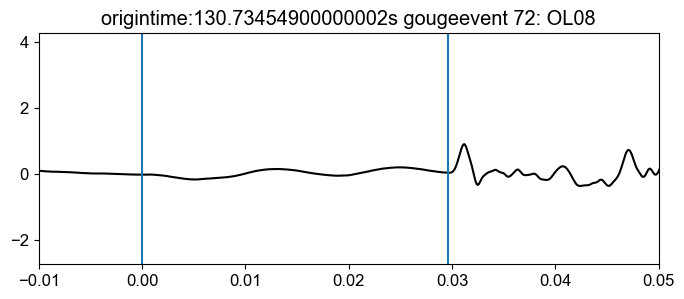

In [16]:
eventid = 72
tr1 = read(outdir+f"/obs_isocoord_OL08__fb03-087__{eventid:04d}.pickle")[0]
print(tr1.stats)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(tr1.times()*1e3-tr1.stats.pretrigger, tr1.data, "k-")
ax.axvline(0)
ax.axvline(tr1.stats.tpick)
ax.set_title(f"origintime:{tr1.stats.origintime}s gougeevent {eventid:g}: {tr1.stats.station}")
ax.set_xlim([-tr1.stats.pretrigger, 0.05])

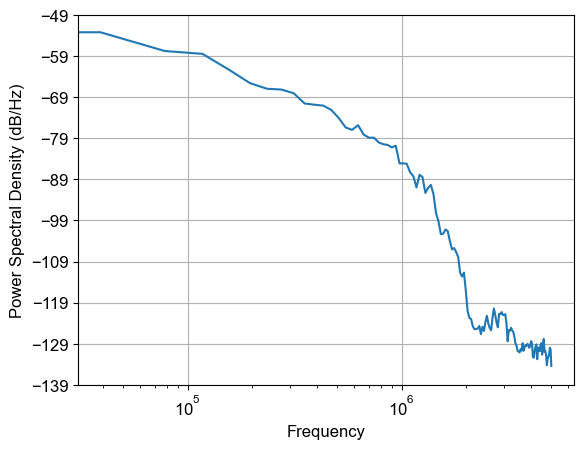

In [17]:
Pxx, freq = plt.psd(tr1.data, Fs=tr1.stats.sampling_rate)
ax = plt.gca()
ax.set_xscale('log')

In [18]:
plt.psd

<function matplotlib.pyplot.psd(x: 'ArrayLike', NFFT: 'int | None' = None, Fs: 'float | None' = None, Fc: 'int | None' = None, detrend: "Literal['none', 'mean', 'linear'] | Callable[[ArrayLike], ArrayLike] | None" = None, window: 'Callable[[ArrayLike], ArrayLike] | ArrayLike | None' = None, noverlap: 'int | None' = None, pad_to: 'int | None' = None, sides: "Literal['default', 'onesided', 'twosided'] | None" = None, scale_by_freq: 'bool | None' = None, return_line: 'bool | None' = None, *, data=None, **kwargs) -> 'tuple[np.ndarray, np.ndarray] | tuple[np.ndarray, np.ndarray, Line2D]'>

## Save green's function location file for OpenSWPC modeling

In [19]:
# save green txt for biax side coord
df_iso_all = pd.read_csv("../data/datacsv/AEevents_isocoord.csv",  index_col=[0])

fo = open("../data/datacsv/green_in_AEevent_biax.txt", "w")
fo.write("# AE event loc for green's function\n#     x     y    z    gid\n# --------------------------------------------------------------------------------------------\n")
gindex = 0
gindex_dict = {}
z_depth = 200e-3 #[m] depth on the fault

for index, row in df_iso_all.iterrows():
    xi1, eta1, zeta1, gid = [row["xi1"], row["eta1"], row["zeta1"], index]
    fo.write("{:.8e} {:.8e} {:.8e} {}\n".format(xi1/1e3, 0, -eta1/1e3, gindex)) # locations are in [km]
    print(index, gindex)
    gindex_dict[index] = gindex
#     print(gindex_dict)
    gindex = gindex+1
    
fo.close()

OL06__fb03-087__0004 0
OL06__fb03-087__0009 1
OL06__fb03-087__0018 2
OL06__fb03-087__0019 3
OL06__fb03-087__0020 4
OL06__fb03-087__0021 5
OL06__fb03-087__0024 6
OL06__fb03-087__0027 7
OL06__fb03-087__0030 8
OL06__fb03-087__0031 9
OL06__fb03-087__0037 10
OL06__fb03-087__0038 11
OL06__fb03-087__0040 12
OL06__fb03-087__0043 13
OL06__fb03-087__0044 14
OL06__fb03-087__0049 15
OL06__fb03-087__0050 16
OL06__fb03-087__0052 17
OL06__fb03-087__0055 18
OL06__fb03-087__0059 19
OL06__fb03-087__0061 20
OL06__fb03-087__0062 21
OL06__fb03-087__0069 22
OL06__fb03-087__0072 23
OL06__fb03-087__0075 24
OL06__fb03-087__0076 25
OL06__fb03-087__0077 26
OL06__fb03-087__0081 27
OL06__fb03-087__0085 28
OL06__fb03-087__0088 29
OL06__fb03-087__0089 30
OL06__fb03-087__0095 31
OL06__fb03-087__0099 32
OL06__fb03-087__0100 33
OL06__fb03-087__0102 34
OL06__fb03-087__0109 35
OL06__fb03-087__0110 36
OL06__fb03-087__0111 37
OL06__fb03-087__0118 38
OL06__fb03-087__0120 39
OL06__fb03-087__0126 40
OL06__fb03-087__0128 41
OL

In [20]:
# save green function index table
df_gindex = pd.DataFrame(gindex_dict.items(), columns=['index', 'gid'])
df_gindex.to_csv("../data/datacsv/gindex_table.csv") 

In [21]:
gindex_dict

{'OL06__fb03-087__0004': 0,
 'OL06__fb03-087__0009': 1,
 'OL06__fb03-087__0018': 2,
 'OL06__fb03-087__0019': 3,
 'OL06__fb03-087__0020': 4,
 'OL06__fb03-087__0021': 5,
 'OL06__fb03-087__0024': 6,
 'OL06__fb03-087__0027': 7,
 'OL06__fb03-087__0030': 8,
 'OL06__fb03-087__0031': 9,
 'OL06__fb03-087__0037': 10,
 'OL06__fb03-087__0038': 11,
 'OL06__fb03-087__0040': 12,
 'OL06__fb03-087__0043': 13,
 'OL06__fb03-087__0044': 14,
 'OL06__fb03-087__0049': 15,
 'OL06__fb03-087__0050': 16,
 'OL06__fb03-087__0052': 17,
 'OL06__fb03-087__0055': 18,
 'OL06__fb03-087__0059': 19,
 'OL06__fb03-087__0061': 20,
 'OL06__fb03-087__0062': 21,
 'OL06__fb03-087__0069': 22,
 'OL06__fb03-087__0072': 23,
 'OL06__fb03-087__0075': 24,
 'OL06__fb03-087__0076': 25,
 'OL06__fb03-087__0077': 26,
 'OL06__fb03-087__0081': 27,
 'OL06__fb03-087__0085': 28,
 'OL06__fb03-087__0088': 29,
 'OL06__fb03-087__0089': 30,
 'OL06__fb03-087__0095': 31,
 'OL06__fb03-087__0099': 32,
 'OL06__fb03-087__0100': 33,
 'OL06__fb03-087__0102':

In [22]:
df_gindex

,index,gid
0,OL06__fb03-087__0004,0
1,OL06__fb03-087__0009,1
2,OL06__fb03-087__0018,2
3,OL06__fb03-087__0019,3
4,OL06__fb03-087__0020,4
...,...,...
259,OL24__fb03-087__0120,259
260,OL24__fb03-087__0126,260
261,OL24__fb03-087__0128,261
262,OL24__fb03-087__0129,262


**NOTE** Now it's ready to conduct numerical simulation to compute Green's tensor.

# Output isoparametric sensor location for the Forward modeling
We output the sensor locations to run the forward modeling (i.e. turn off the  green's mode) to check the waveforms.

In [23]:
df_iso_all

,OL,datacase,xs,ys,zs,xi,eta,zeta,xi1,eta1,zeta1,incidentangle,azimuth,rlen_sourcedist,llen
OL06__fb03-087__0004,OL06,fb03-087__0004,1.370,0.05,0.07,1.7475,0.00505,0,0.3775,-0.04495,0,83.322379,83.209600,0.386558,0.380167
OL06__fb03-087__0009,OL06,fb03-087__0009,1.370,0.05,0.07,1.7425,0.00375,0,0.3725,-0.04625,0,83.042867,82.922316,0.381832,0.375360
OL06__fb03-087__0018,OL06,fb03-087__0018,1.370,0.05,0.07,1.7460,0.00375,0,0.3760,-0.04625,0,83.104843,82.987540,0.385247,0.378834
OL06__fb03-087__0019,OL06,fb03-087__0019,1.370,0.05,0.07,1.7425,0.00300,0,0.3725,-0.04700,0,82.931181,82.808735,0.381923,0.375453
OL06__fb03-087__0020,OL06,fb03-087__0020,1.370,0.05,0.07,1.7460,0.00325,0,0.3760,-0.04675,0,83.031030,82.912496,0.385307,0.378895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OL24__fb03-087__0120,OL24,fb03-087__0120,2.035,-0.05,0.07,1.7470,0.00400,0,0.2880,-0.05400,0,79.674227,79.380345,0.301264,0.293019
OL24__fb03-087__0126,OL24,fb03-087__0126,2.035,-0.05,0.07,1.7440,-0.00050,0,0.2910,-0.04950,0,80.609118,80.346214,0.303367,0.295180
OL24__fb03-087__0128,OL24,fb03-087__0128,2.035,-0.05,0.07,1.7480,0.00625,0,0.2870,-0.05625,0,79.219295,78.910989,0.300721,0.292460
OL24__fb03-087__0129,OL24,fb03-087__0129,2.035,-0.05,0.07,1.7435,0.00125,0,0.2915,-0.05125,0,80.298799,80.028466,0.304136,0.295971


In [24]:
ys_burry = 1e-3 #  [m] burry the sensor in the rock for the stability of computation

fo = open("../data/datacsv/stloc_forward.txt", "w")
fo.write("#      x     y     z       stnm   zsw\n# --------------------------------------------------------------------------------------------\n")

for index, row in df_iso_all.iterrows():
    sensor_x = row["xs"] - row["xi"]
    sensor_y = row["zs"]
    
    if row["ys"] > 0:
        # south side
        sensor_z = ys_burry
    else:
        # north side
        sensor_z = W/1e3 - ys_burry
        
    fo.write("{:.8e} {:.8e} {:.8e} {} dep\n".format(sensor_x/1e3, sensor_y/1e3, sensor_z/1e3, row["OL"])) # locations are in [km]
    
fo.close()


In [25]:
W/2/1e3

0.05

In [26]:
# # save green txt for side coordinate
# fo = open("../data/green_in_AEevent_sidecoord.txt", "w")
# fo.write("# AE event loc for green's function\n#     x     y    z    gid\n# --------------------------------------------------------------------------------------------\n")
# gindex = 0
# gindex_dict = {}
# for index, row in df_iso_all.iterrows():
#     xi1, eta1, zeta1, gid = [row["xi1"], row["eta1"], row["zeta1"], index]
#     fo.write("{:.8e} {:.8e} {:.8e} {}\n".format(xi1/1e3, z_depth/1e3, -eta1/1e3, gindex)) # locations are in [km]
#     gindex_dict[index] = gindex
#     gindex = gindex+1
    
# fo.close()

In [27]:
# # save green function index table
# df_gindex = pd.DataFrame(gindex_dict.items(), columns=['index', 'gid'])
# df_gindex.to_csv("../data/gindex_table_sidecoord.csv")